In [21]:
%load_ext autoreload
%autoreload 2
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import experiments
import utils
from granularity import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
np.random.seed(42)
with open('data/gt_canary_od_pretty_02042020.json') as f:
    dataset = json.load(f)

In [62]:
cols = ["item", "uid", "annotation", "groundtruth", "nbc_consolidation", "image_properties"]

NUM_ITEMS = 200
i = 0
rows = []
image_id_to_gt_dict = {}
for image_key, all_data in dataset.items():
    i+=1
    if i > NUM_ITEMS:
        break
    raw_annotations_dict = all_data['worker_answers']
    gt = all_data['ground_truth']['annotations']
    image_id_to_gt_dict[image_key] = gt
    nbc_cons = all_data['consolidated_answers']['answerContent']['boundingBox']['boundingBoxes'] 
    image_properties = all_data['consolidated_answers']['answerContent']['boundingBox']['inputImageProperties']
    for worker_id, anno in raw_annotations_dict.items():
        stripped_anno = anno['answerContent']['boundingBox']['boundingBoxes']                                                      
        row = [image_key, worker_id, stripped_anno, gt, nbc_cons, image_properties]
        rows.append(row)
df = pd.DataFrame(rows, columns=cols)

In [63]:
df

,item,uid,annotation,groundtruth,nbc_consolidation,image_properties
0,99f64b43a39faef6.jpg,public.us-east-1.A2VOC7DMBTU46D,"[{'height': 27.0, 'width': 55.0, 'top': 932.0,...","[{'class_id': 0, 'height': 26.24000000000001, ...","[{'height': 37.16666666666666, 'width': 37.833...","{'height': 1024, 'width': 683}"
1,99f64b43a39faef6.jpg,public.us-east-1.AK35CJJEYFVYK,"[{'height': 45.0, 'width': 30.0, 'top': 898.0,...","[{'class_id': 0, 'height': 26.24000000000001, ...","[{'height': 37.16666666666666, 'width': 37.833...","{'height': 1024, 'width': 683}"
2,99f64b43a39faef6.jpg,public.us-east-1.A3FFUWSE5C6QFZ,"[{'height': 58.0, 'width': 41.0, 'top': 889.0,...","[{'class_id': 0, 'height': 26.24000000000001, ...","[{'height': 37.16666666666666, 'width': 37.833...","{'height': 1024, 'width': 683}"
3,99f64b43a39faef6.jpg,public.us-east-1.A3UXXT6KP7MIRG,"[{'height': 47.0, 'width': 32.0, 'top': 896.0,...","[{'class_id': 0, 'height': 26.24000000000001, ...","[{'height': 37.16666666666666, 'width': 37.833...","{'height': 1024, 'width': 683}"
4,99f64b43a39faef6.jpg,public.us-east-1.A39L5W9N08RN33,"[{'height': 48.0, 'width': 33.0, 'top': 893.0,...","[{'class_id': 0, 'height': 26.24000000000001, ...","[{'height': 37.16666666666666, 'width': 37.833...","{'height': 1024, 'width': 683}"
...,...,...,...,...,...,...
1795,8b75573711592e03.jpg,public.us-east-1.A3O0EYFA3CCZ92,"[{'height': 109.0, 'width': 65.0, 'top': 379.0...","[{'class_id': 0, 'height': 110.71948800000001,...","[{'height': 115.25, 'width': 83.75, 'top': 375...","{'height': 768, 'width': 1024}"
1796,8b75573711592e03.jpg,public.us-east-1.ACJ12KIXGZZFH,"[{'height': 70.0, 'width': 50.0, 'top': 295.0,...","[{'class_id': 0, 'height': 110.71948800000001,...","[{'height': 115.25, 'width': 83.75, 'top': 375...","{'height': 768, 'width': 1024}"
1797,8b75573711592e03.jpg,public.us-east-1.A3KKENI2RQO12O,"[{'height': 151.0, 'width': 94.0, 'top': 358.0...","[{'class_id': 0, 'height': 110.71948800000001,...","[{'height': 115.25, 'width': 83.75, 'top': 375...","{'height': 768, 'width': 1024}"
1798,8b75573711592e03.jpg,public.us-east-1.A16TEDRTHI8H9F,"[{'height': nan, 'width': nan, 'top': nan, 'le...","[{'class_id': 0, 'height': 110.71948800000001,...","[{'height': 115.25, 'width': 83.75, 'top': 375...","{'height': 768, 'width': 1024}"


In [64]:
def convert2vr(annotations):
    result = []
    for annotation in annotations:
        left = annotation["left"]
        top = annotation["top"]
        if annotation["width"] > 0 and annotation["height"] > 0:
            result.append(VectorRange([left, top], [left + annotation["width"], top + annotation["height"]]))
        else:
            return np.nan
    return result

if "raw_labels" not in df.columns:
    df["raw_labels"] = df["annotation"]
if "raw_gold" not in df.columns:
    df["raw_gold"] = df["groundtruth"]
    
df["annotation"] = df["raw_labels"].apply(convert2vr).dropna()
df["groundtruth"] = df["raw_gold"].apply(convert2vr).dropna()

In [177]:
def iou_score(vrA, vrB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(vrA.start_vector[0], vrB.start_vector[0])
    yA = max(vrA.start_vector[1], vrB.start_vector[1])
    xB = min(vrA.end_vector[0], vrB.end_vector[0])
    yB = min(vrA.end_vector[1], vrB.end_vector[1])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (vrA.end_vector[0] - vrA.start_vector[0] + 1) * (vrA.end_vector[1] - vrA.start_vector[1] + 1)
    boxBArea = (vrB.end_vector[0] - vrB.start_vector[0] + 1) * (vrB.end_vector[1] - vrB.start_vector[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou



def iou_score_multi(vrAs, vrBs):
    scoresA = [np.max([iou_score(vrA, vrB) for vrB in vrBs] + [0]) for vrA in vrAs]
    scoresB = [np.max([iou_score(vrA, vrB) for vrA in vrAs] + [0]) for vrB in vrBs]
    score = np.mean(scoresA + scoresB)
    return 0 if np.isnan(score) else score


In [178]:
bb_experiment = experiments.RealExperiment(eval_fn=iou_score_multi,label_colname="annotation",
                                                    item_colname="item", uid_colname="uid")

bb_experiment.setup(annodf=df, golddf=df, c_gold_item="item", c_gold_label="groundtruth")

100%|██████████| 200/200 [00:08<00:00, 23.61it/s]


In [179]:
def merge_mean(annotations):
    vrs = [vr for annotation in annotations for vr in annotation]
    mean_start = np.array([vr.start_vector for vr in vrs]).mean(axis=0)
    mean_end = np.array([vr.end_vector for vr in vrs]).mean(axis=0)
    return [VectorRange(mean_start, mean_end)]

mean_preds = bb_experiment.annodf.groupby("item").agg({"annotation":merge_mean})["annotation"].to_dict()
bb_experiment.register_baseline("MEAN MERGE", mean_preds)


In [180]:
bb_experiment.train(iter=0)
bb_experiment.test(debug=False)
# bb_experiment.debug(plot_vs_gold=True, skip_miniplots=True)

Pickled model loaded
BEST AVAILABLE USER
0.5725106002025941 0.6478674335488478
t-test Ttest_relResult(statistic=-13.102480595393905, pvalue=2.6027481218193495e-36)
z-score 0.41454414071033624
baseline below thresh 0.0
model below thresh 0.0
SMALLEST AVERAGE DISTANCE
0.5725106002025941 0.6654911488712765
t-test Ttest_relResult(statistic=-17.271168712318897, pvalue=1.0969908928966314e-58)
z-score 0.5464355959762623
baseline below thresh 0.0
model below thresh 0.0
HEURISTIC
0.5725106002025941 0.6675550538645012
t-test Ttest_relResult(statistic=-17.812797841150342, pvalue=7.508160960624522e-62)
z-score 0.5635719832550233
baseline below thresh 0.0
model below thresh 0.0
MEAN MERGE
0.5725106002025941 0.18242194098124412
t-test Ttest_relResult(statistic=52.014827416235526, pvalue=1.479721504546428e-286)
z-score -1.6456763113268749
baseline below thresh 0.0
model below thresh 0.0
ORACLE
0.5725106002025941 0.745156316020659
t-test Ttest_relResult(statistic=-33.50078195375674, pvalue=1.530669788

In [181]:
bb_experiment.annodf

,uid,item,annotation,pred_uerr
0,97,135,"[([603.0, 932.0], [658.0, 959.0]), ([508.0, 90...",0.618141
1,178,135,"[([427.0, 898.0], [457.0, 943.0]), ([518.0, 90...",0.543061
2,126,135,"[([418.0, 889.0], [459.0, 947.0]), ([516.0, 90...",0.473068
3,157,135,"[([426.0, 896.0], [458.0, 943.0]), ([520.0, 91...",0.492477
4,119,135,"[([425.0, 893.0], [458.0, 941.0]), ([518.0, 90...",0.580346
...,...,...,...,...
1794,73,122,"[([22.0, 365.0], [125.0, 497.0]), ([198.0, 273...",0.572303
1795,141,122,"[([51.0, 379.0], [116.0, 488.0]), ([203.0, 279...",0.587807
1796,167,122,"[([483.0, 295.0], [533.0, 365.0]), ([713.0, 28...",0.741812
1797,136,122,"[([32.0, 358.0], [126.0, 509.0]), ([56.0, 286....",0.488708


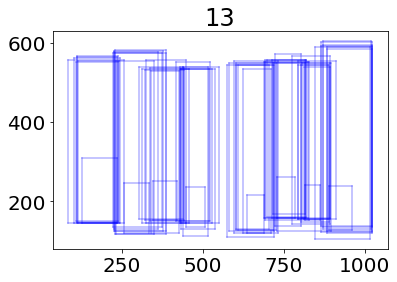

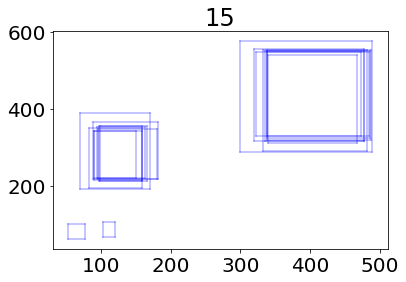

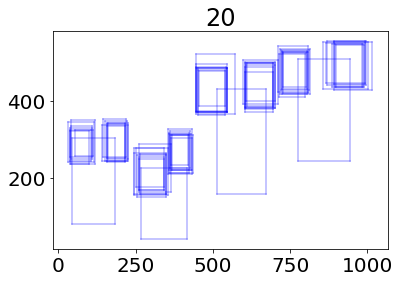

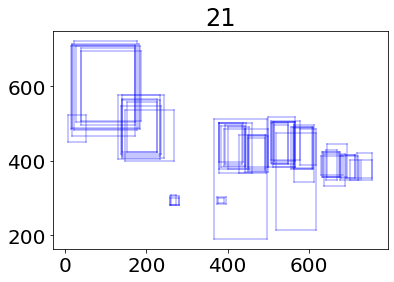

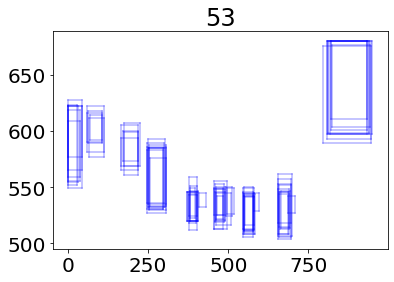

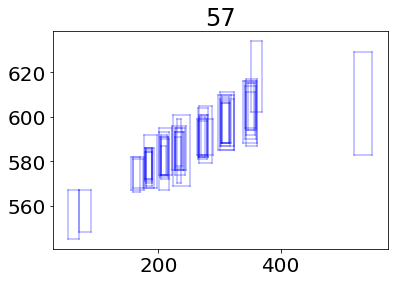

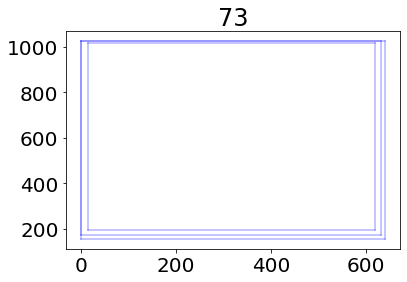

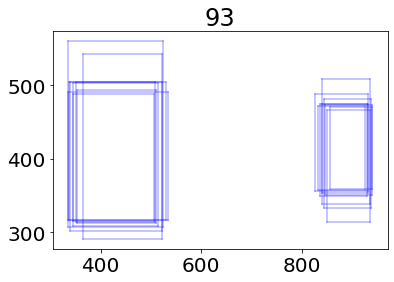

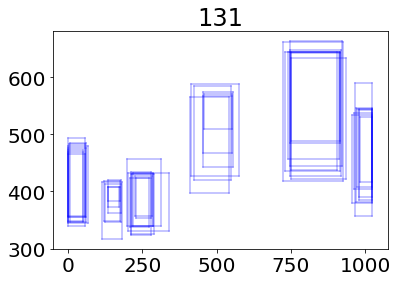

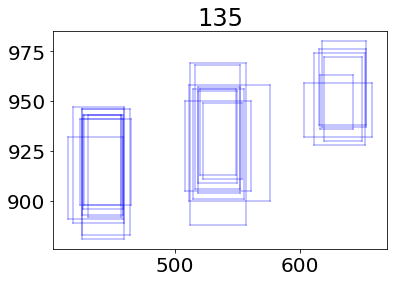

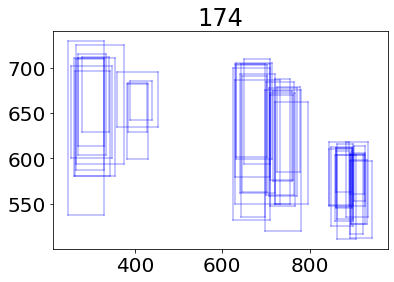

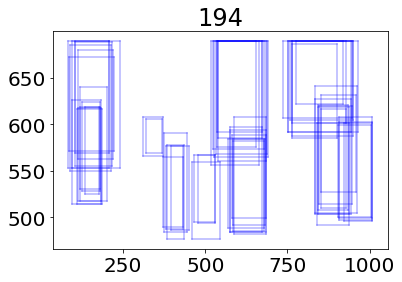

""


In [182]:
def plot_vectorrange(vr, color="b", alpha=0.3):
    plt.plot([vr.start_vector[0], vr.end_vector[0]], [vr.start_vector[1], vr.start_vector[1]], color, alpha=alpha)
    plt.plot([vr.start_vector[0], vr.start_vector[0]], [vr.start_vector[1], vr.end_vector[1]], color, alpha=alpha)
    plt.plot([vr.start_vector[0], vr.end_vector[0]], [vr.end_vector[1], vr.end_vector[1]], color, alpha=alpha)
    plt.plot([vr.end_vector[0], vr.end_vector[0]], [vr.start_vector[1], vr.end_vector[1]], color, alpha=alpha)

def plot_annos(data):
    vrs = [vr for annotation in data["annotation"] for vr in annotation]
    for vr in vrs:
        plot_vectorrange(vr)
    plt.title(data["item"].values[0])
    plt.show()

bb_experiment.annodf.iloc[:100].groupby("item").apply(plot_annos)
    


In [183]:
granno_df = fragment_by_overlaps(bb_experiment.annodf)

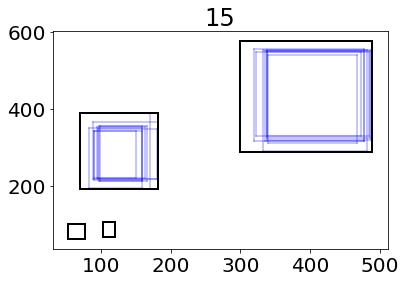

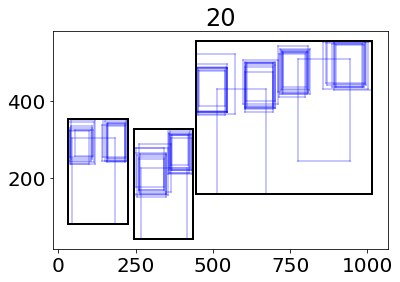

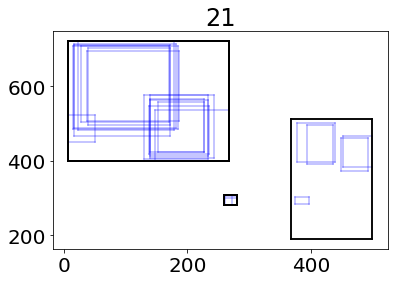

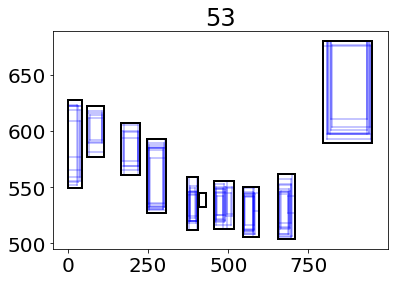

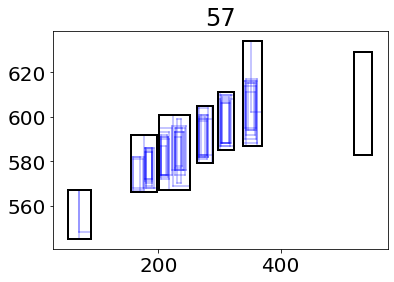

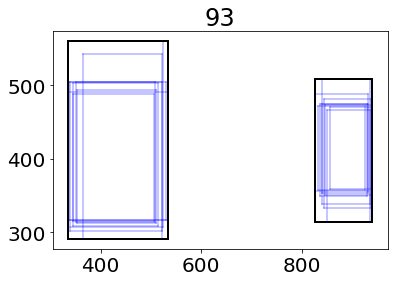

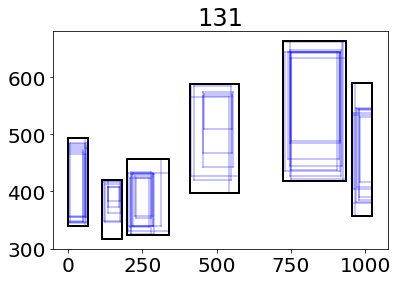

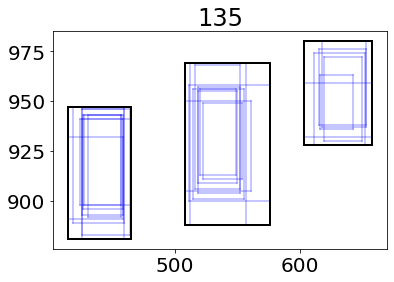

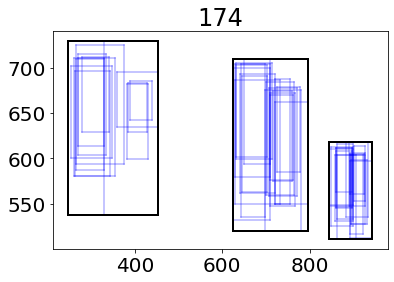

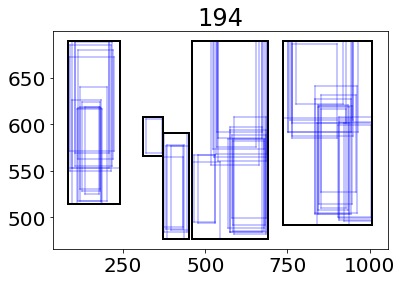

""


In [184]:

def plot_grannos(data):
    for vr in [vr for annotation in data["annotation"] for vr in annotation]:
        plot_vectorrange(vr)
    for vr in data["newItemVR"].values:
        plot_vectorrange(vr, color="k", alpha=1)
    plt.title(data["origItemID"].values[0])
    plt.show()

granno_df.iloc[:400].groupby("origItemID").apply(plot_grannos)
    

In [185]:
granno_df

,origItemID,newItemID,newItemVR,uid,annotation,gold
0,135,"135-([414.0, 881.0], [465.0, 947.0])","([414.0, 881.0], [465.0, 947.0])",97,"[([414.0, 891.0], [458.0, 932.0])]",None
1,135,"135-([414.0, 881.0], [465.0, 947.0])","([414.0, 881.0], [465.0, 947.0])",178,"[([427.0, 898.0], [457.0, 943.0])]",None
2,135,"135-([414.0, 881.0], [465.0, 947.0])","([414.0, 881.0], [465.0, 947.0])",126,"[([418.0, 889.0], [459.0, 947.0])]",None
3,135,"135-([414.0, 881.0], [465.0, 947.0])","([414.0, 881.0], [465.0, 947.0])",157,"[([426.0, 896.0], [458.0, 943.0])]",None
4,135,"135-([414.0, 881.0], [465.0, 947.0])","([414.0, 881.0], [465.0, 947.0])",119,"[([425.0, 893.0], [458.0, 941.0])]",None
...,...,...,...,...,...,...
75,122,"122-([969.0, 309.0], [1024.0, 418.0])","([969.0, 309.0], [1024.0, 418.0])",73,"[([980.0, 312.0], [1024.0, 400.0])]",None
76,122,"122-([969.0, 309.0], [1024.0, 418.0])","([969.0, 309.0], [1024.0, 418.0])",141,"[([986.0, 338.0], [1014.0, 413.0])]",None
77,122,"122-([969.0, 309.0], [1024.0, 418.0])","([969.0, 309.0], [1024.0, 418.0])",167,"[([977.0, 309.0], [1024.0, 402.0])]",None
78,122,"122-([969.0, 309.0], [1024.0, 418.0])","([969.0, 309.0], [1024.0, 418.0])",136,"[([969.0, 314.0], [1024.0, 406.0])]",None


In [186]:
gran_exp = experiments.RealExperiment(bb_experiment.eval_fn, "annotation", "newItemID", "uid")
gran_exp.setup(granno_df, merge_index="origItemID")
gran_exp.annodf

  0%|          | 0/544 [00:00<?, ?it/s]/Users/alexbraylan/Tools/annotationmodeling/mas/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/alexbraylan/Tools/annotationmodeling/mas/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 544/544 [00:21<00:00, 25.89it/s]


,uid,newItemID,annotation,origItemID
0,97,113,"[([414.0, 891.0], [458.0, 932.0])]",135
1,178,113,"[([427.0, 898.0], [457.0, 943.0])]",135
2,126,113,"[([418.0, 889.0], [459.0, 947.0])]",135
3,157,113,"[([426.0, 896.0], [458.0, 943.0])]",135
4,119,113,"[([425.0, 893.0], [458.0, 941.0])]",135
...,...,...,...,...
75,73,78,"[([980.0, 312.0], [1024.0, 400.0])]",122
76,141,78,"[([986.0, 338.0], [1014.0, 413.0])]",122
77,167,78,"[([977.0, 309.0], [1024.0, 402.0])]",122
78,136,78,"[([969.0, 314.0], [1024.0, 406.0])]",122


In [187]:
gran_exp.train(iter=0)

Pickled model loaded


In [188]:
gmean_preds = gran_exp.annodf.groupby("newItemID").agg({"annotation":merge_mean})["annotation"].to_dict()
gran_exp.register_baseline("MEAN MERGE", gmean_preds)

In [189]:
gran_exp.test_merged(bb_experiment.golddict)

BEST AVAILABLE USER
0.0375827917637704 0.6614145579304903
t-test Ttest_relResult(statistic=-93.09024707907874, pvalue=0.0)
z-score 2.94524507805611
baseline below thresh 0.0
model below thresh 0.0
BEST HONEYPOT USER
0.0375827917637704 0.0
t-test Ttest_relResult(statistic=13.823059990476601, pvalue=6.7641415133005136e-40)
z-score -0.43734226385757763
baseline below thresh 0.0
model below thresh 0.0
SMALLEST AVERAGE DISTANCE
0.0375827917637704 0.6789282860056696
t-test Ttest_relResult(statistic=-99.68077764532966, pvalue=0.0)
z-score 3.1537602374963867
baseline below thresh 0.0
model below thresh 0.0
HEURISTIC
0.0375827917637704 0.6804384449790163
t-test Ttest_relResult(statistic=-102.43444053248109, pvalue=0.0)
z-score 3.2408822757279436
baseline below thresh 0.0
model below thresh 0.0
MULTIDIMENSIONAL ANNOTATION SCALING
0.0375827917637704 0.0
t-test Ttest_relResult(statistic=13.823059990476601, pvalue=6.7641415133005136e-40)
z-score -0.43734226385757763
baseline below thresh 0.0
model 

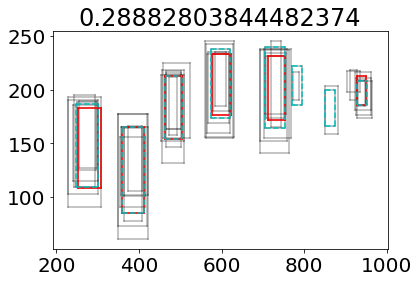

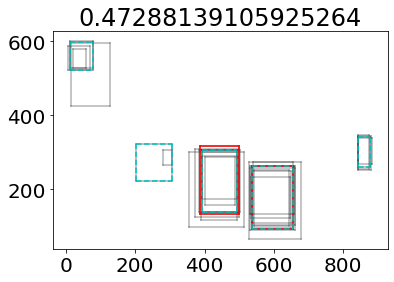

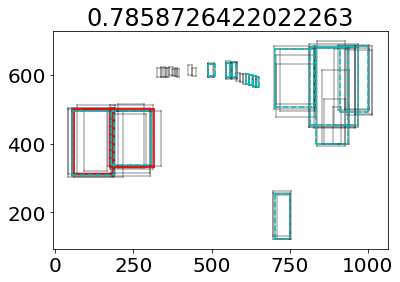

[([59.0, 311.0], [183.0, 502.0]), ([176.0, 331.0], [316.0, 501.0])] 
vs
 [([54.0, 308.0], [188.0, 495.0]), ([179.0, 338.0], [305.0, 495.0]), ([489.0, 596.0], [510.0, 632.0]), ([545.0, 594.0], [560.0, 635.0]), ([567.0, 594.0], [580.0, 638.0]), ([612.0, 575.0], [620.0, 603.0]), ([620.0, 571.0], [632.0, 600.0]), ([634.0, 568.0], [643.0, 597.0]), ([642.0, 566.0], [653.0, 593.0]), ([702.0, 123.0], [753.0, 254.0]), ([704.0, 507.0], [829.0, 675.0]), ([814.0, 454.0], [968.0, 680.0]), ([836.0, 399.0], [936.0, 677.0]), ([912.0, 492.0], [1002.0, 685.0])]
dist= 0.7858726422022263


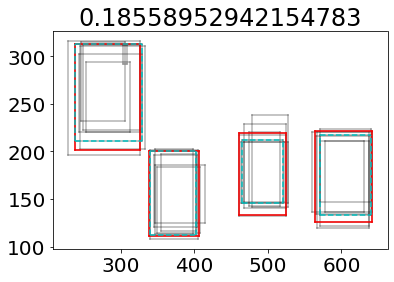

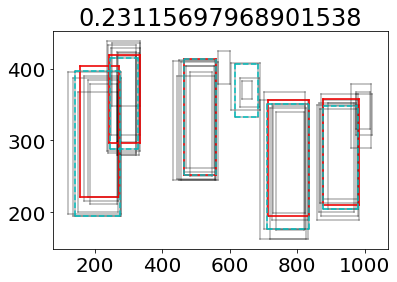

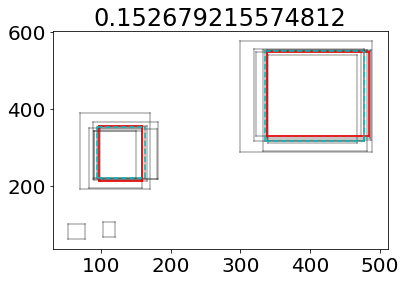

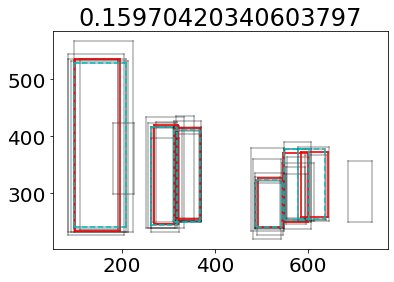

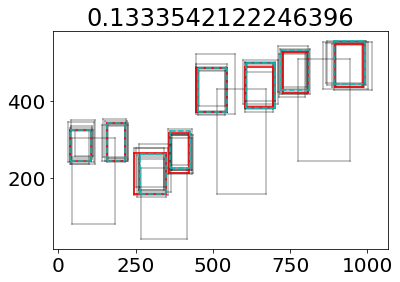

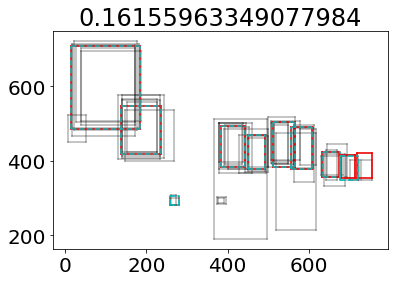

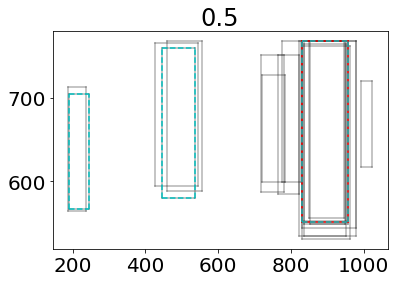

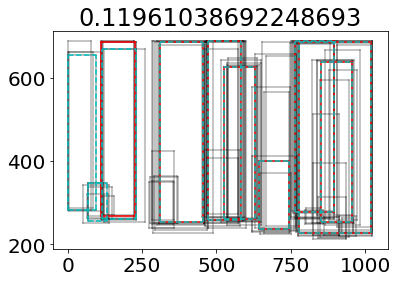

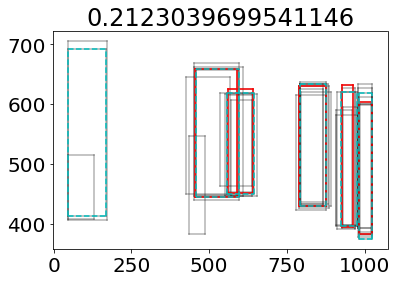

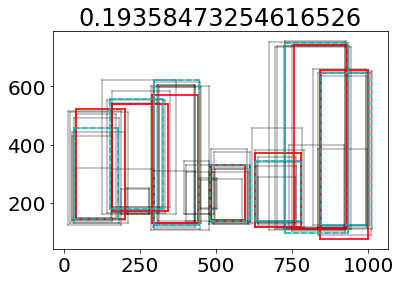

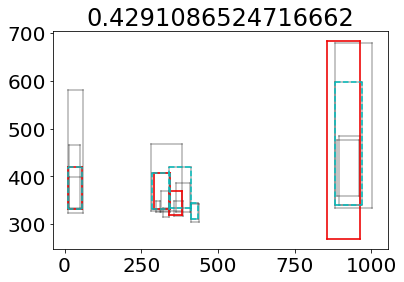

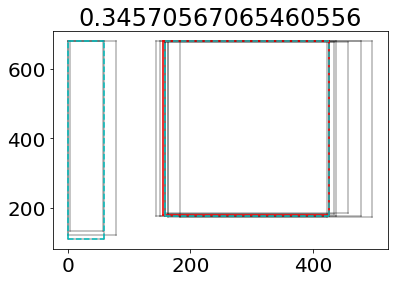

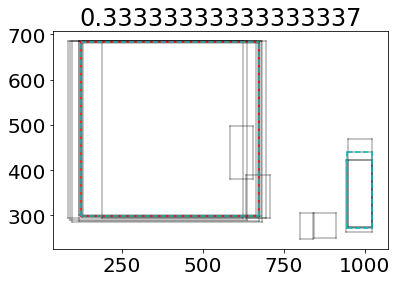

In [192]:
for i in range(len(bb_experiment.annodf))[:50]:
    sad_orig = bb_experiment.sad_preds.get(i)
    sad_gran = gran_exp.sad_preds.get(i)
    dist = bb_experiment.distance_fn(sad_orig, sad_gran)
    if dist < 0.1:
        continue
    
    idf = bb_experiment.annodf[bb_experiment.annodf["item"]==i]
    
    vrs = [vr for annotation in idf["annotation"] for vr in annotation]
    for vr in vrs:
        plot_vectorrange(vr, "k")
    for vr in sad_orig:
        plot_vectorrange(vr, "r", 1)
    for vr in sad_gran:
        plot_vectorrange(vr, "c--", 1)
    plt.title(dist)
    plt.show()
    if dist > 0.5:
        print(sorted(sad_orig), "\nvs\n", sorted(sad_gran))
        sdist = bb_experiment.distance_fn(sorted(sad_orig), sorted(sad_gran))
        print("dist=", sdist)
